In [1]:
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image

In [2]:
dcm1 = 'ct1.dcm'  # 普通CT例子
dcm2 = 'ct2.dcm'  # 背景为-2000CT值，带亮班 的例子
# dcm3 = 'petct.dcm'  # PETCT例子

## PIL库中图像失真问题

In [3]:
img_open=pydicom.read_file(dcm1)
img_array=img_open.pixel_array
img_array = np.array(img_array, dtype=np.float32)  # 转换数据类型为float32

print('数据形状：', img_array.shape)
print('数据最大值：', img_array.max(), '数据最小值：', img_array.min())

数据形状： (512, 512)
数据最大值： 2242.0 数据最小值： 0.0


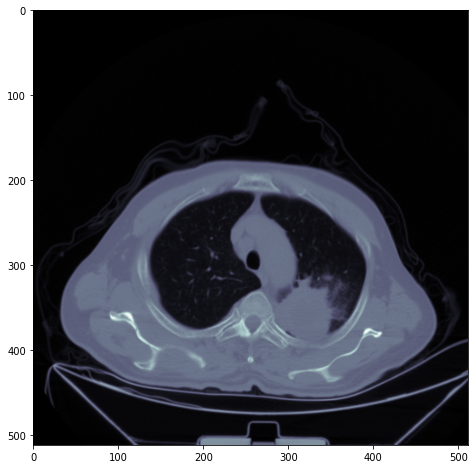

In [4]:
# 用matplotlib显示，此时没问题
plt.figure(figsize=(8, 8))
plt.imshow(img_array, cmap=plt.cm.bone)
plt.show()

F
L


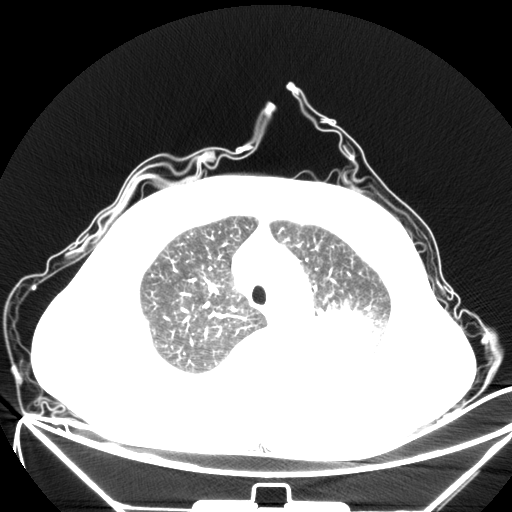

In [5]:
# 传入Image.fromarray后，convert成
img_array_pil = Image.fromarray(img_array)
print(img_array_pil.mode)

img = img_array_pil.convert('L')
print(img.mode)
img

由于图像矩阵传入PIL库后，模式（mode）一般是F（浮点型）或I（整形），无法进一步处理（比如另存为jpg图像格式、在notebook中显示等）。<br>
所以我们一般会使用 convert 方法转换mode，灰度图我们一般转成 "L" 模式。<br>
但是这样会导致图像失真，如上图所示！
|模式|说明|
|--|--|
|1|             1位像素，黑和白，存成8位的像素|
|L|             8位像素，黑白|
|P|             8位像素，使用调色板映射到任何其他模式|
|RGB|           3×8位像素，真彩|
|RGBA|          4×8位像素，真彩+透明通道|
|CMYK|          4×8位像素，颜色隔离|
|YCbCr|         3×8位像素，彩色视频格式|
|I|             32位整型像素|
|F|             32位浮点型像素|

In [6]:
# 验证图像失真
print(img_array.sum(), np.array(img_array_pil).sum(), np.array(img).sum())

91494420.0 91494420.0 31735015


以上可以看到 convert('L') 后，图像矩阵的数值已经产生了变化，解释了为什么显示出来的图像和plt.imshow()显示的有很大的差别

## 使用最小最大值归一化（Min-Max Normalization）预处理
我们发现使用convert方法对数值范围的要求在 0~255 之间。而这张图像的矩阵的数值最高达到了2242，所以convert时出现了问题。<br>
最小最大值归一化（Min-Max Normalization）可将矩阵全体数值线性映射到[0, 1]之间。<br>
最后再全体乘以255即可。

In [7]:
img_open=pydicom.read_file(dcm1)
img_array=img_open.pixel_array
img_array = np.array(img_array, dtype=np.float32)  # 转换一下数据类型为float32

print('数据形状：', img_array.shape)
print('数据最大值：', img_array.max(), '数据最小值：', img_array.min())

数据形状： (512, 512)
数据最大值： 2242.0 数据最小值： 0.0


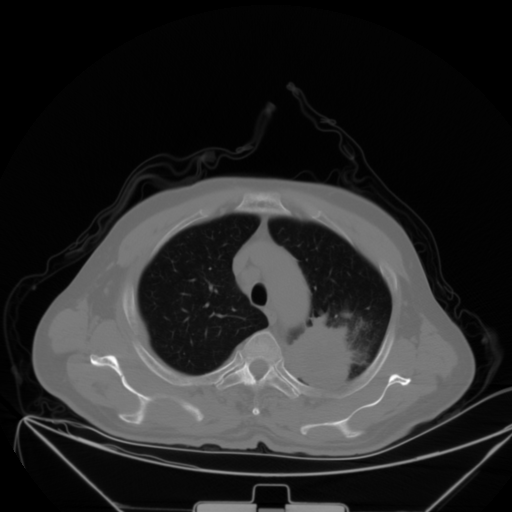

In [8]:
max_value = img_array.max()
min_value = img_array.min()
img_array = (img_array - min_value) / (max_value - min_value)
img_array = img_array * 255

img_array_pil = Image.fromarray(img_array)
img = img_array_pil.convert('L')
img

In [9]:
# 验证图像失真
print(img_array.sum(), np.array(img_array_pil).sum(), np.array(img).sum())

10406366.0 10406366.0 10287779


以上经过最小最大值归一化，并乘以255后，图像基本就不失真了！

## 消除过暗过亮值
在实际情况中，不少CT图像的矩阵存在背景数值(CT值)为-2000，并且还会有带极高亮斑的情况。<br>
这种光光做Min-Max Normalization是不够的。

In [10]:
img_open=pydicom.read_file(dcm2)
img_array=img_open.pixel_array
img_array = np.array(img_array, dtype=np.float32)  # 转换一下数据类型为float32

print('数据形状：', img_array.shape)
print('数据最大值：', img_array.max(), '数据最小值：', img_array.min())

数据形状： (512, 512)
数据最大值： 9435.0 数据最小值： -2000.0


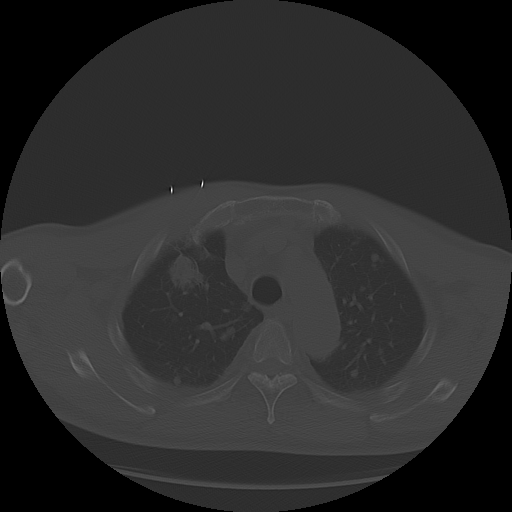

In [11]:
# 显示图像
max_value = img_array.max()
min_value = img_array.min()
img_array = (img_array - min_value) / (max_value - min_value)
img_array = img_array * 255

img_array_pil = Image.fromarray(img_array)
img = img_array_pil.convert('L')
img

以上我们发现经过Min-Max Normalization后，图像变得非常暗淡。<br>
我们计算了数据最大值： 9435.0 ，数据最小值： -2000.0<br>
我们查看一下图像矩阵的一行。

In [12]:
img_open.pixel_array[200]

array([-2000, -2000, -2000, -2000, -2000, -2000,    44,    44,    -4,
         -34,    23,    18,   113,    53,   -47,    60,    42,   -16,
          94,    75,    14,    42,   -31,   -11,    37,    72,    34,
         -45,    51,    18,    37,    -4,    48,    48,   118,    88,
          80,    20,     1,    13,   104,     5,     3,    18,   103,
          33,    75,    89,    79,   -38,    69,   -30,    49,    69,
          60,    51,   -13,     7,   -11,    71,    69,    -2,    13,
         -12,   -27,    69,   108,   -13,    83,    45,    69,    48,
         -18,    42,    39,    28,     9,    47,    57,    76,   103,
          72,    54,    38,    37,    60,    43,    35,    93,    53,
          64,   102,    95,    62,   114,    12,   -16,    35,    12,
          81,    98,    74,    19,     5,    38,    86,   135,    36,
          59,    69,    29,    60,    73,    50,    19,   114,    71,
          -9,    35,    40,    24,    -6,    60,   125,    53,    35,
         129,    56,

可以发现背景的数值是 -2000，并且普通组织区域的数值大约在0~3000左右。<br>
最大值9435应该对应的是图像中的某个亮斑，属于干扰值。<br>
我们可以将图像进行进一步处理，将-2000的部分改成0，大于3000的值改成3000

数据形状： (512, 512)
数据最大值： 3000.0 数据最小值： 0.0


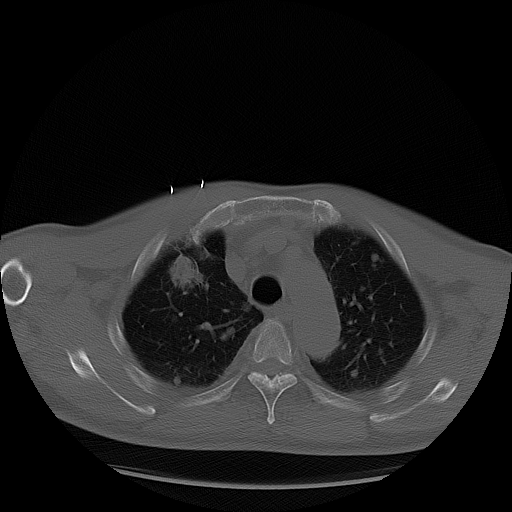

In [13]:
img_array = img_open.pixel_array
img_array = np.array(img_array, dtype=np.float32)  # 转换一下数据类型为float32

img_array = np.maximum(img_array, 0)  # 消除-2000 CT值
img_array = np.minimum(img_array, 3000)  # 消除极亮值

print('数据形状：', img_array.shape)
print('数据最大值：', img_array.max(), '数据最小值：', img_array.min())

# 最小最大值归一化
max_value = img_array.max()
min_value = img_array.min()
img_array = (img_array - min_value) / (max_value - min_value)
img_array = img_array * 255

img_array_pil = Image.fromarray(img_array)
img = img_array_pil.convert('L')
img

以上就正常多了

## pytorch中对tensor使用最小最大值归一化处理（torchvision.transforms）
torchvision.transforms中没有对应最小最大值归一化的方法。<br>
想要在pytorch数据处理中使用最小最大值归一化，可以自己写一个方法放入transoms.Compose中。<br>
消除过暗过亮值 和 最小最大值归一化 处理后的CT图像数据在训练时有助于收敛并提高模型准确率指标。

In [17]:
from torchvision import transforms
import torch

def NormalizeTensor(data):
    minimal = torch.min(data)
    return (data - minimal) / (torch.max(data) - minimal)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    NormalizeTensor,
])

In [18]:
img_open=pydicom.read_file(dcm2)
img_array = img_open.pixel_array
img_array = np.array(img_array, dtype=np.float32)

# 消除过暗过亮值
img_array = np.maximum(img_array, 0)  # 消除-2000 CT值
img_array = np.minimum(img_array, 3000)  # 消除极亮值

img_array_pil = Image.fromarray(img_array)
img = img_array_pil.convert('L')

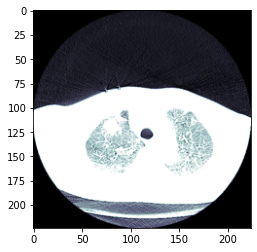

In [19]:
img_tensor = transform(img)
plt.imshow(img_tensor.permute([1,2,0]), cmap=plt.cm.bone)